# Libraries

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.non_parametric_tests import *
from utils.PerformanceProfiles  import *
from utils.PerformanceMetrics   import RegressionEvaluation

# Import data

In [33]:
from os import listdir
from os.path import isfile, join

path = 'Predictions/'
Files = [f for f in listdir( path ) if isfile(join(path, f))]

print('[INFO] Number of methods: ', len(Files) )

[INFO] Number of methods:  3


In [34]:
Results = []
df      = None
for file in Files:
    # Get method
    Method = file.split('.')[0]    
    # Load data
    temp = pd.read_csv(path + file, index_col = 0)
    
    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( temp )
    Results.append( [Method, MAE, RMSE, MAPE, SMAPE, R2] )
    
    # Calculate Absolute Errors
    temp[ Method ] = (temp.iloc[:,0] - temp.iloc[:,1]).abs().round(4)
    # Keep only errors
    temp = temp[ Method ]
    
    if (df is None):
        df = temp
    else:
        df = pd.concat([df, temp], axis=1)
        

# df.head( 3 )

In [35]:
# df = df[ ['ResNet', 'NBeats', 'Seq2Seq_LSTM']]

# Performance evaluation based on metrics

In [36]:
Results = pd.DataFrame(data = Results, columns = ['Method', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'R2'] )

Results['MAE']   = Results['MAE'].apply(lambda x: np.round(x,3))
Results['RMSE']  = Results['RMSE'].apply(lambda x: np.round(x,3))
Results['MAPE']  = Results['MAPE'].apply(lambda x: np.round(x,3))
Results['SMAPE'] = Results['SMAPE'].apply(lambda x: np.round(x,3))
Results['R2']    = Results['R2'].apply(lambda x: np.round(x,4))


Results.sort_values(by = 'Method', ignore_index = True)

,Method,MAE,RMSE,MAPE,SMAPE,R2
0,Hybrid,0.810,1.533,29.632,27.371,0.5021
1,Hybrid_a,0.810,1.545,28.848,27.222,0.4943
2,Hybrid_b,0.807,1.524,29.546,27.177,0.5079


# Performance profiles

- Dolan, E. D., & Moré, J. J. (2002). Benchmarking optimization software with performance profiles. Mathematical programming, 91(2), 201-213.
ISO 690	


              Hybrid solved 23.87% of cases with the best (least) score
            Hybrid_a solved 42.95% of cases with the best (least) score
            Hybrid_b solved 33.94% of cases with the best (least) score


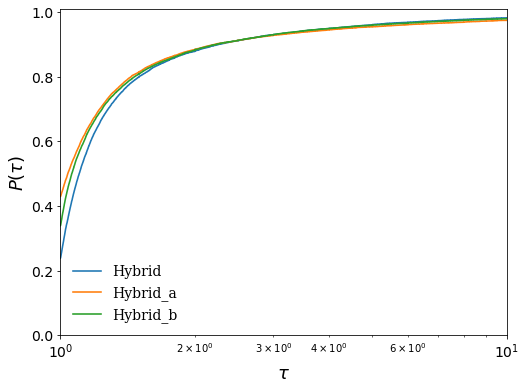

In [37]:
perfprof(df, 
#          linespecs = ['r-', 'b-', 'g--', 'c-.', 'm-.', 'y--'], 
         digit       = 3,
         legendnames = df.columns,
         thmax       = 10, 
         figsize     = (8, 6))

plt.xscale('log')

# Statistical analysis

- Derrac, J., García, S., Molina, D., & Herrera, F. (2011). A practical tutorial on the use of nonparametric statistical tests as a methodology for comparing evolutionary and swarm intelligence algorithms. Swarm and Evolutionary Computation, 1(1), 3-18.

- García, S., Fernández, A., Luengo, J., & Herrera, F. (2010). Advanced nonparametric tests for multiple comparisons in the design of experiments in computational intelligence and data mining: Experimental analysis of power. Information sciences, 180(10), 2044-2064.

In [38]:
# df = df[:10000]

## Friedman Aligned Ranking (FAR)

In [39]:
T, p_value, rankings_avg, rankings_cmp = friedman_aligned_ranks_test( df )


# Summary
#
print('\n')
print('[INFO] H0: {All methods exhibited similar results with no statistical differences}')
print('[INFO] FAR: %.3f (p-value: %.5f)' % (T, p_value))
if (p_value < 0.05):
    print('\t> H0 is rejected')
else:
    print('\t> H0 is failed to be rejected')

[INFO] Number of methods:   3
[INFO] Number of problems:  17108


[INFO] H0: {All methods exhibited similar results with no statistical differences}
[INFO] FAR: 23.423 (p-value: 0.00001)
	> H0 is rejected


### FAR ranking

In [40]:
Ranking            = pd.DataFrame( [] )
Ranking['Methods'] = df.columns
Ranking['FAR']     = rankings_avg

Ranking = Ranking.sort_values(by           = 'FAR', 
                              ignore_index = True)
Ranking

,Methods,FAR
0,Hybrid_b,25205.304565
1,Hybrid_a,25645.785510
2,Hybrid,26136.409925


## Finner post-hoc test

In [11]:
# Create dictionary with rankings
#
d = {}
for i, feature in enumerate( df.columns ):
    d[ feature ] = rankings_cmp[i] 

### Multiple comparisons ($1 \times N$)

**Finner post-hoc test**

In [12]:
comparisons, z_values, p_values, adj_p_values = finner_test( d )

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner = Finner.sort_values(by = 'APV', ascending = False, ignore_index = True)
Finner

[INFO] Control method:  Seq2Seq_LSTM_diff


,Comparisons,APV,Null hypothesis
0,Seq2Seq_LSTM_diff vs NBeats_diff,7.688773e-01,Failed to reject
1,Seq2Seq_LSTM_diff vs Hybrid,1.540770e-07,Rejected


In [13]:
# Ranking['Methods'] = ['Seq2Seq LSTM (Hybrid)', 'Seq2Seq LSTM + (d-diff)', 'NBeats', 'NBeats + (d-diff)', 'RF + (d-diff)', 'Seq2Seq LSTM', 'RF']
# #
# Ranking = Ranking.sort_values(by = 'FAR', ignore_index = True)
# Ranking['APV'] = '-'
# Ranking['APV'][1:] = Finner['APV']
# Ranking['Null hypothesis'] = '-'
# Ranking['Null hypothesis'][1:] = Finner['Null hypothesis']
# Ranking


### Multiple comparisons ($N \times N$)

**Finner-multitest post-hoc test**

In [14]:
comparisons, z_values, p_values, adj_p_values = finner_multitest(d)

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner

,Comparisons,APV,Null hypothesis
0,Hybrid vs Seq2Seq_LSTM_diff,2.311154e-07,Rejected
1,Hybrid vs NBeats_diff,5.658934e-07,Rejected
2,NBeats_diff vs Seq2Seq_LSTM_diff,7.688773e-01,Failed to reject
